# Toy M&M analysis on Thyroid and Lung
This analysis uses some early prototypes of M&M. 

Current implementation of M&M in [`libgaow`](https://github.com/gaow/libgaow/tree/master/py/src) is coded in Python and, inspired [by this version of algorithm in the univarate case](https://github.com/gaow/libgaow/tree/master/py/src), encapsulates lots of computation in MASH. Also it has not implemented ELBO calculation yet.

For convenience of prototyping, I use Python implementation of MASH core computations (also in `libgaow`). Also I'll do an interactive analysis rather than running pipelines.

## Overview of procedures

We start with $N \approx 800$ samples and $R = 2$ conditions (thyroid and lung), on about $J = 7500$ effects for given gene FMO2.

1. Run `MASH` on $\hat{\beta}_{P \times R}$ and $S_{P \times R}$ where $P$ is the number of genes in GTEx data for these tissues: this is the standard MASH procedure where we learn the prior matrices from top eQTLs in data and their weights from null eQTLs. 
  - Output is prior matrices and their weights, i.e, the hyperparameters
2. Given these hyperparameters, run M&M in parallel on all genes (in this case the given gene FMO2)
  - Output is $\tilde{\beta}_{P \times R}$ and $\tilde{S}_{P \times R}$
3. With these updates, run step 1 - 3, and repeat this until convergence.

## MASH on Thyroid and Lung

In [1]:
input_data = "~/Documents/GTExV8/MASH/GTExV8.ciseQTL.4MASH.rds"
setwd('~/Documents/GTExV8/MNM')

### SFA

In [2]:
z = readRDS(input_data)$max$z
z = z[,c('Thyroid', 'Lung')]
write.table(z, "/tmp/mnm.max.txt", col.names=F,row.names=F)
cmd = paste0('~/Documents/GTExV8/utils/sfa/bin/sfa_linux -gen /tmp/mnm.max.txt -g ', dim(z)[1], ' -n ', dim(z)[2], 
                 ' -k 2 -iter 50 -rand 999 -o /tmp/mnm.max')
system(cmd)
saveRDS(list(F = read.table("/tmp/mnm.max_F.out"),
             lambda = read.table("/tmp/mnm.max_lambda.out"),
             sigma2 = read.table("/tmp/mnm.max_sigma2.out"),
             alpha = read.table("/tmp/mnm.max_alpha.out")), 'TL_MASH.sfa.rds')

### Prior covariates

In [3]:
sfa_data = readRDS("TL_MASH.sfa.rds")
mash_data = mashr::set_mash_data(z, matrix(1, nrow(z), ncol(z)))
sfa_res = as.matrix(sfa_data$lambda) %*% as.matrix(sfa_data$F)
# SFA matrices
U.sfa = c(mashr::cov_from_factors(as.matrix(sfa_data$F), "sfa2"), list("tSFA" = t(sfa_res) %*% sfa_res / nrow(z)))
# SVD matrices
U.pca = mashr::cov_pca(mash_data, 2)
# Emperical data matrices
# `cov_ed` will take significantly longer when this empirical convariance matrix is added
D.center = apply(as.matrix(z), 2, function(x) x - mean(x))
# Denoised data-driven matrices
U.dd = c(U.sfa, U.pca, list("XX" = t(D.center) %*% D.center / nrow(z)))
U.ed = mashr::cov_ed(mash_data, U.dd)
# Canonical matrices
U.can = mashr::cov_canonical(mash_data)
saveRDS(list(Ulist = c(U.ed, U.can), DD_raw = U.dd), 'TL_MASH.priors.rds')

### Fit mixture model

In [4]:
dat = readRDS(input_data)
z = as.matrix(dat$null$z)[,c('Thyroid', 'Lung')]
V = cor(z[which(apply(abs(z),1, max) < 2),])
mash_data = mashr::set_mash_data(as.matrix(z), matrix(1, nrow(z), ncol(z)), as.matrix(V))
saveRDS(mashr::mash(mash_data, Ulist = readRDS('TL_MASH.priors.rds')$Ulist, usepointmass = FALSE, outputlevel = 1), 'TL_MASH.fit.rds')

 - Computing 140688 x 266 likelihood matrix.
 - Likelihood calculations took 3.97 seconds.
 - Fitting model with 266 mixture components.
 - Model fitting took 98.52 seconds.


In [3]:
dat = readRDS('TL_MASH.fit.rds')
str(dat)

List of 6
 $ result     : NULL
 $ loglik     : num -529366
 $ vloglik    : num [1:140688, 1] -2.74 -5.14 -4.4 -3.01 -5.05 ...
 $ null_loglik: NULL
 $ alt_loglik : NULL
 $ fitted_g   :List of 4
  ..$ pi          : num [1:266] 3.43e-02 2.38e-11 1.15e-11 1.47e-11 8.48e-12 ...
  ..$ Ulist       :List of 14
  .. ..$ ED_sfa2_1    : num [1:2, 1:2] 0.763 0.874 0.874 1
  .. ..$ ED_sfa2_2    : num [1:2, 1:2] 1 0.645 0.645 0.416
  .. ..$ ED_tSFA      : num [1:2, 1:2] 1 0.847 0.847 0.761
  .. ..$ ED_PCA_1     : num [1:2, 1:2] 1 0.789 0.789 0.623
  .. ..$ ED_PCA_2     : num [1:2, 1:2] 0.623 -0.789 -0.789 1
  .. ..$ ED_tPCA      : num [1:2, 1:2] 1 0.435 0.435 0.511
  .. ..$ ED_XX        : num [1:2, 1:2] 1 0.646 0.646 0.546
  .. ..$ identity     : num [1:2, 1:2] 1 0 0 1
  .. ..$ Thyroid      : num [1:2, 1:2] 1 0 0 0
  .. ..$ Lung         : num [1:2, 1:2] 0 0 0 1
  .. ..$ equal_effects: num [1:2, 1:2] 1 1 1 1
  .. ..$ simple_het_1 : num [1:2, 1:2] 1 0.25 0.25 1
  .. ..$ simple_het_2 : num [1:2, 1:2] 1

In [4]:
Ulist = mashr::expand_cov(dat$fitted_g$Ulist, dat$fitted_g$grid, usepointmass = dat$fitted_g$usepointmass)
U_names = names(Ulist)
pi_s = dat$fitted_g$pi
which.comp = (pi_s > 1E-10)
U_names = U_names[which.comp]
pi_s = pi_s[which.comp]
print(length(Ulist))
print(length(pi_s))

[1] 266
[1] 3


In [5]:
%get Ulist U_names pi_s --from R

Loading required package: feather


In [6]:
from collections import OrderedDict
U = OrderedDict([(k, Ulist[k.replace('.', '_')]) for k in U_names])

In [7]:
pi_s

[0.034297587641094, 0.965702411817388, 3.21374405172067e-10]

In [8]:
U

OrderedDict([('ED_sfa2_1.1', array([[ 0.00637227,  0.00729445],
                     [ 0.00729445,  0.00835008]])),
             ('Thyroid.1', array([[ 0.00835008,  0.        ],
                     [ 0.        ,  0.        ]])),
             ('Lung.1', array([[ 0.        ,  0.        ],
                     [ 0.        ,  0.00835008]]))])

## M&M model

In [2]:
dat = readRDS('/home/gaow/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds')
attach(dat)

In [10]:
%get X Y --from R
Y = Y.as_matrix()

### Use MASH weights as is
These weights are learned from 2 tissues in the MASH EB framework, without `null` component -- because the `null` will have almost 100% weight in MASH! Need to figure out what's going on.

Here, without `null`, as shown in 2 cells above, thyroid specific prior has heightest weight (over 96%).

In [11]:
from libgaow.regression_data import MNMASH
model = MNMASH(X=X,Y=Y)

In [12]:
model.set_prior(U, pi = pi_s)

In [ ]:
model.fit(niter = 100)

In [16]:
import numpy as np
np.save('mnm_post_mean.npy', model.post_mean_mat)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

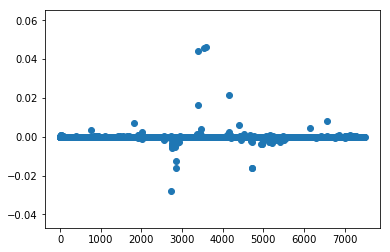

In [18]:
plt.scatter([x+1 for x in range(len(model.post_mean_mat[:,0]))], model.post_mean_mat[:,0], cmap="viridis")
ax = plt.gca()
plt.show()

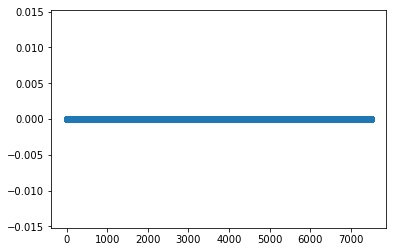

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter([x+1 for x in range(len(model.post_mean_mat[:,1]))], model.post_mean_mat[:,1], cmap="viridis")
ax = plt.gca()
plt.show()

In [21]:
model.post_mean_mat

array([[ -1.16714215e-06,  -9.57805811e-07],
       [ -1.07089187e-06,  -1.07757631e-06],
       [ -1.74139775e-08,  -1.99337615e-08],
       ..., 
       [  1.38934526e-05,   1.51437123e-07],
       [ -3.08697086e-08,  -3.53005829e-08],
       [  1.48079839e-05,   1.71193685e-07]])

### Use a modified weight base on experience
- We know that at least 50% genes has eQTL so I will set `null` weight to 0.5
- We know that thyroid has more eQTLs than lung (or just more power to detect them?) and we assume half of those are shared:
  - Thyroid specific weight: 0.25
  - Lung specific weight 0.1
  - Shared weight: 0.15

I then modify `U` and `pi_s` and re-fit.

In [22]:
U['null'] = np.zeros((2,2))
U

OrderedDict([('ED_sfa2_1.1', array([[ 0.00637227,  0.00729445],
                     [ 0.00729445,  0.00835008]])),
             ('Thyroid.1', array([[ 0.00835008,  0.        ],
                     [ 0.        ,  0.        ]])),
             ('Lung.1', array([[ 0.        ,  0.        ],
                     [ 0.        ,  0.00835008]])),
             ('null', array([[ 0.,  0.],
                     [ 0.,  0.]]))])

In [36]:
pi_s = [0.15,0.25,0.1,0.5]

In [37]:
model2 = MNMASH(X=X,Y=Y)
model2.set_prior(U, pi = pi_s)
model2.fit(niter = 100)

In [38]:
np.save('mnm_assigned_post_mean.npy', model2.post_mean_mat)

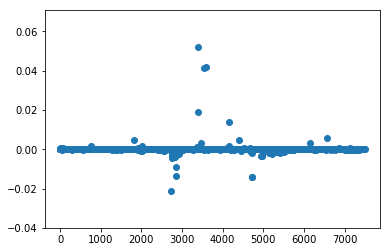

In [40]:
plt.scatter([x+1 for x in range(len(model2.post_mean_mat[:,0]))], model2.post_mean_mat[:,0], cmap="viridis")
ax = plt.gca()
plt.show()

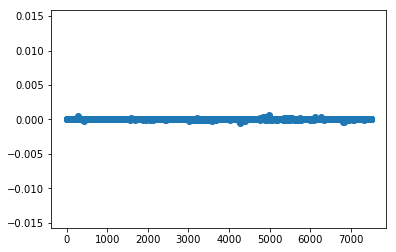

In [41]:
plt.scatter([x+1 for x in range(len(model2.post_mean_mat[:,1]))], model2.post_mean_mat[:,1], cmap="viridis")
ax = plt.gca()
plt.show()

In [43]:
model2.mash.U

OrderedDict([('ED_sfa2_1.1', array([[ 0.00637227,  0.00729445],
                     [ 0.00729445,  0.00835008]])),
             ('Thyroid.1', array([[ 0.00835008,  0.        ],
                     [ 0.        ,  0.        ]])),
             ('Lung.1', array([[ 0.        ,  0.        ],
                     [ 0.        ,  0.00835008]])),
             ('null', array([[ 0.,  0.],
                     [ 0.,  0.]]))])

In [44]:
model2.mash.pi

array([ 0.15,  0.25,  0.1 ,  0.5 ])

## Compare with `varbvs`

In [6]:
n <- nrow(X)
p <- ncol(X)
set.seed(1)
varbvs_fit1 <- varbvs::varbvs(X,NULL, Y[,1],verbose = FALSE)
varbvs_bhat1 = rowSums(varbvs_fit1$alpha*varbvs_fit1$mu)

In [12]:
varbvs_fit2 <- varbvs::varbvs(X,NULL, Y[,2],verbose = FALSE)
varbvs_bhat2 = rowSums(varbvs_fit2$alpha*varbvs_fit2$mu)

In [16]:
varbvs_bhat1 = as.vector(varbvs_bhat1)
varbvs_bhat2 = as.vector(varbvs_bhat2)


In [17]:
%get varbvs_bhat1 varbvs_bhat2 --from R

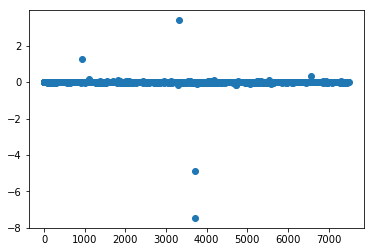

In [20]:
plt.scatter([x+1 for x in range(len(varbvs_bhat1))], varbvs_bhat1, cmap="viridis")
ax = plt.gca()
plt.show()

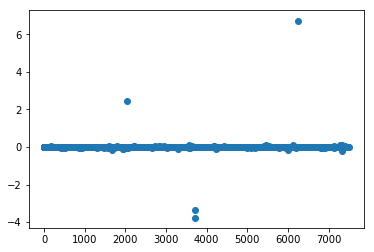

In [23]:
plt.scatter([x+1 for x in range(len(varbvs_bhat2))], varbvs_bhat2, cmap="viridis")
ax = plt.gca()
plt.show()